# Grounded Segement Anything

![gdgligen](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

**Why this project?**
- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks. 
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text. 
- The combination of the two models enable to **detect and segment everything** with text inputs!

# Prepare Environments

In [ ]:
! python -m pip install -e segment_anything
! python -m pip install -e GroundingDINO
! pip install diffusers transformers accelerate scipy safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Obtaining file:///home/shm/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment_anything
    Found existing installation: segment_anything 1.0
    Uninstalling segment_anything-1.0:
      Successfully uninstalled segment_anything-1.0
  DEPRECATION: Legacy editable install of segment_anything==1.0 from file:///home/shm/Grounded-Segment-Anything/segment_anything (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for segment_anything


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Obtaining file:///home/shm/Grounded-Segment-Anything/GroundingDINO
  Installing build dependencies ... /

In [1]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

In [2]:
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [18]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

# Load Grounding DINO model

In [19]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [20]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [21]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

final text_encoder_type: bert-base-uncased


Model loaded from /home/shm/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


# Load SAM model

In [23]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

# Load stable diffusion inpainting models

In [24]:
from diffusers import StableDiffusionInpaintPipeline

if DEVICE.type == 'cpu':
    float_type = torch.float32
else:
    float_type = torch.float16

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=float_type,
)

if DEVICE.type != 'cpu':
    pipe = pipe.to("cuda")

Loading pipeline components...: 100%|████████████████████████████████| 6/6 [00:01<00:00,  4.41it/s]


# Load demo image

In [25]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

# download_image(image_url, local_image_path)

# Load image here

In [52]:
local_image_path = 'assets/inpaint_demo.jpg'

# Run Grounding DINO for detection

In [53]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2

TEXT_PROMPT = "cabinet"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=groundingdino_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD,
    device=DEVICE
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

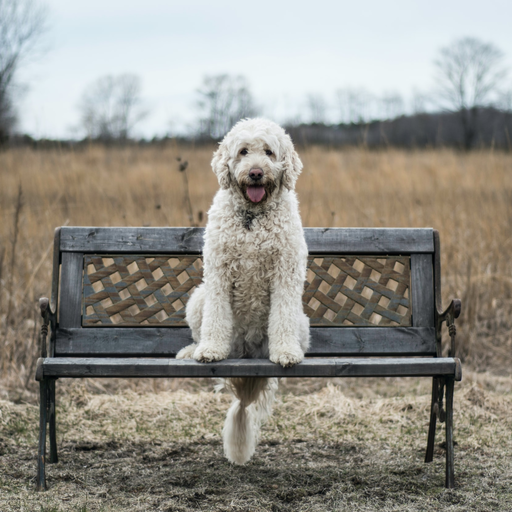

In [54]:
Image.fromarray(image_source)

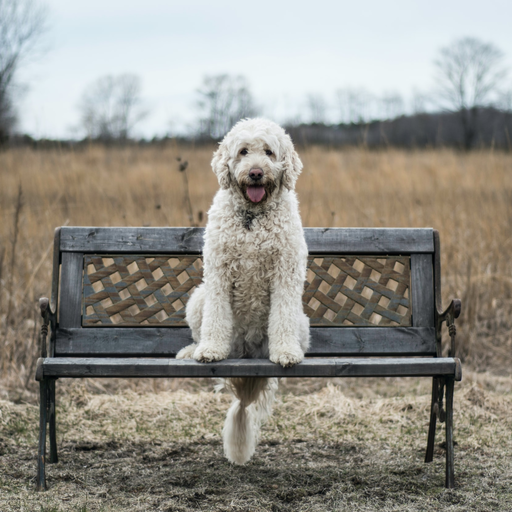

In [55]:
Image.fromarray(annotated_frame)

# Run the segmentation model

In [56]:
# set image
sam_predictor.set_image(image_source)

In [57]:
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [58]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )


RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous

In [34]:
from PIL import Image
import numpy as np
import torch

def show_mask(mask, image, random_color=True):
    # Check if mask is a PyTorch tensor and move to CPU if necessary
    if isinstance(mask, torch.Tensor) and mask.is_cuda:
        mask = mask.cpu()

    # Ensure mask is numpy array
    mask = mask.numpy() if isinstance(mask, torch.Tensor) else mask
    
    # Define color
    if random_color:
        color = np.random.random(3)
        color = np.concatenate([color, [0.8]])
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    
    # Make sure the mask is of shape (height, width) and has 1 channel
    h, w = mask.shape[-2:]
    mask_image = np.zeros((h, w, 4), dtype=np.float32)
    mask_image[..., :3] = color[:3]  # RGB
    mask_image[..., 3] = mask * color[3]  # Alpha channel
    
    # Convert the image to RGBA
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

    # Composite the mask onto the image
    result = Image.alpha_composite(annotated_frame_pil, mask_image_pil)

    return np.array(result)

In [35]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

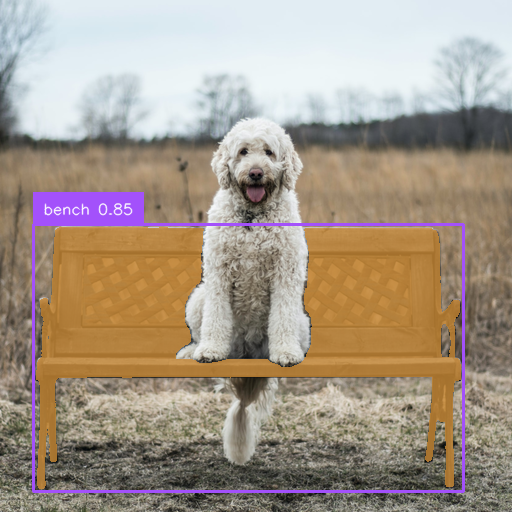

In [37]:
Image.fromarray(annotated_frame_with_mask)

In [44]:
import numpy as np
from PIL import Image
import os

# Extract the base name and extension
base_name, ext = os.path.splitext(os.path.basename(local_image_path))

# Convert all images to NumPy arrays
image_source_np = np.array(image_source_pil)
image_mask_np = np.array(image_mask_pil)

# Ensure the mask is binary (True or False), and if it's not already, convert it
binary_mask = (image_mask_np > 0).astype(np.uint8)

# Create a 4-channel RGBA image (for transparency)
if image_source_np.shape[2] == 3:  # If the source is RGB, not RGBA
    image_source_rgba = np.dstack((image_source_np, np.full(image_source_np.shape[:2], 255, dtype=np.uint8)))  # Add alpha channel (255 for opaque)
else:
    image_source_rgba = image_source_np

# Apply the mask: Set pixels outside the mask to black (RGB) and alpha=255 (fully opaque)
image_source_rgba[binary_mask == 0, :3] = [0, 0, 0]  # Set RGB to black where mask is 0 (background)
image_source_rgba[binary_mask == 0, 3] = 255  # Ensure alpha is 255 (opaque) where mask is 0 (background)

# Convert the array to uint8 to ensure compatibility with PIL
image_source_rgba = image_source_rgba.astype(np.uint8)

# Convert back to PIL Image
image_with_mask_pil = Image.fromarray(image_source_rgba)

# Define the folder path
folder_path = '/home/shm/Grounded-Segment-Anything/Duy/Bg-removals'

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the full path for the saved image
save_path = os.path.join(folder_path, f"{base_name}.png")

# Save the result
image_with_mask_pil.save(save_path)

# Display the result (optional)
# image_with_mask_pil.show()


# Image Inpainting

In [40]:
image_mask = masks[0][0].cpu().numpy()

In [41]:
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

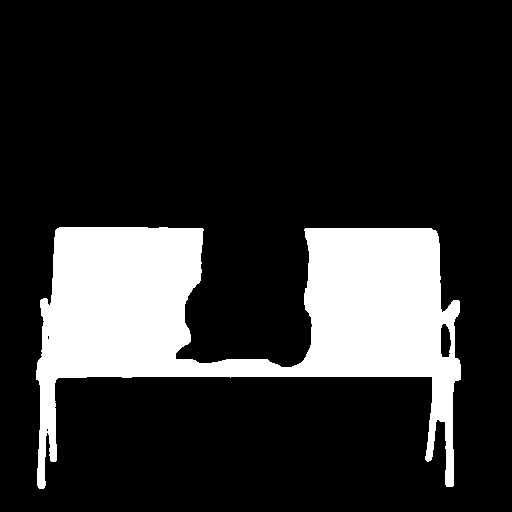

In [42]:
image_mask_pil

In [43]:
import cv2
import numpy as np
from PIL import Image
import os

# Convert PIL Image to NumPy array and ensure it's of type uint8
image_mask_np = np.array(image_mask_pil).astype(np.uint8) * 255  # Multiply by 255 to convert bool to 0 and 255

# Extract the base name and extension
base_name, ext = os.path.splitext(os.path.basename(local_image_path))

# Define the folder path and ensure it exists
folder_path = '/home/shm/Grounded-Segment-Anything/Duy/masks'
os.makedirs(folder_path, exist_ok=True)

# Define the full path for the saved image
save_path = os.path.join(folder_path, f"{base_name}.png.png")

# Save the image using cv2.imwrite
cv2.imwrite(save_path, image_mask_np)

True